In [1]:
from time import time

t0 = time()

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import wave
import soundfile as sf
import os
import librosa
import numpy as np
import glob
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

In [3]:
def get_features(file_name):

    if file_name: 
        X, sample_rate = sf.read(file_name, dtype='float32')

    mfccs = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40)
    mfccs_scaled = np.mean(mfccs.T,axis=0)
    return mfccs_scaled

In [4]:
def extract_features():

    sub_dirs = os.listdir('/ESC-10/audio')
    sub_dirs.sort()
    features_list = []
    for label, sub_dir in enumerate(sub_dirs):  
        for file_name in glob.glob(os.path.join('/ESC-10/audio/',sub_dir,"*.wav")):
            print("Extracting file ", file_name)
            try:
                mfccs = get_features(file_name)
            except Exception as e:
                print("Extraction error")
                continue
            features_list.append([mfccs,label])

    features_df = pd.DataFrame(features_list,columns = ['feature','class_label'])
    print(features_df.head())    
    return features_df

In [5]:
def get_numpy_array(features_df):

    X = np.array(features_df.feature.tolist())
    y = np.array(features_df.class_label.tolist())
    le = LabelEncoder()
    yy = to_categorical(le.fit_transform(y))
    return X,yy,le

def get_train_test(X,y):
    
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 42)
    return  X_train, X_test, y_train, y_test

In [6]:
print("Extracting features..")

features_df = extract_features()

Extracting features..
                                             feature  class_label
0  [-309.30853, 88.03026, 1.5384002, 14.649376, -...            0
1  [-309.30853, 88.03026, 1.5384002, 14.649376, -...            0
2  [-281.61264, 103.59526, -8.473426, 7.9012995, ...            0
3  [-281.61264, 103.59526, -8.473426, 7.9012995, ...            0
4  [-324.52615, -3.5978088, -57.639755, 6.270338,...            0


In [7]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D
from keras.models import load_model

In [8]:
def create_cnn(num_labels):

    model = Sequential()
    model.add(Conv1D(64, 3, activation='relu', input_shape=(40, 1)))
    model.add(Conv1D(64, 3, activation='relu'))
    model.add(MaxPooling1D(3))
    model.add(Conv1D(128, 3, activation='relu'))
    model.add(Conv1D(128, 3, activation='relu'))
    model.add(GlobalAveragePooling1D())
    model.add(Dropout(0.5))
    model.add(Dense(num_labels))
    model.add(Activation('softmax'))
    
    return model

In [9]:
def train(model,X_train, X_test, y_train, y_test,model_file):    
    
    model.compile(loss = 'categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

    print(model.summary())

    print("training for 100 epochs with batch size 32")
   
    history = model.fit(X_train,y_train,batch_size= 32, epochs = 50, validation_data=(X_test,y_test))
    
    print("Saving model to disk")
    model.save(model_file)
    return history

def compute(X_test,y_test,model_file):

    loaded_model = load_model(model_file)
    score = loaded_model.evaluate(X_test,y_test)
    return score[0],score[1]*100


In [10]:
def predict(filename,le,model_file):

    model = load_model(model_file)
    prediction_feature = get_features(filename)
    if model_file == "trained_new.h5":    
        prediction_feature = np.expand_dims(np.array([prediction_feature]),axis=2)

    predicted_vector = model.predict_classes(prediction_feature)
    predicted_class = le.inverse_transform(predicted_vector)
    print("Predicted class",predicted_class[0])
    if predicted_class[0] == 0:
        print("Baby cry")
    elif predicted_class[0] == 1:
        print("Clock alarm")
    elif predicted_class[0] == 2:
        print("Glass breaking")
    elif predicted_class[0] == 3:
        print("Tap open")
    elif predicted_class[0] == 4:
        print("Door knock")

        
    predicted_proba_vector = model.predict([prediction_feature])

    predicted_proba = predicted_proba_vector[0]
    for i in range(len(predicted_proba)): 
        category = le.inverse_transform(np.array([i]))
        print(category[0], "\t\t : ", format(predicted_proba[i], '.32f') )

In [11]:
X, y, le = get_numpy_array(features_df)

In [12]:
X_train, X_test, y_train, y_test = get_train_test(X,y)
num_labels = y.shape[1]

In [13]:
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)

In [14]:
model = create_cnn(num_labels)

In [15]:
print("Training..")
history = train(model,X_train, X_test, y_train, y_test,"trained_new.h5")

Training..
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 255, 64)           256       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 253, 64)           12352     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 84, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 82, 128)           24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 80, 128)           49280     
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dropout (Dropout)            (None, 128)     

In [16]:
test_loss, test_accuracy = compute(X_test,y_test,"trained_new.h5")
print("Test loss",test_loss)
print("Test accuracy",test_accuracy)
print("time taken :", time() - t0)

4/4 [==============================] - 0s 3ms/step - loss: 0.1291 - accuracy: 0.9667
Test loss 0.12914779782295227
Test accuracy 96.66666388511658
time taken : 43.034138441085815


In [18]:
predict("/audio/5 - Tap open/1-51436-A-17.wav",le,"trained_new.h5")

lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Predicted class 3
Tap open
0 		 :  0.00000005175124684342335967812687
1 		 :  0.00000000000017072607704730208278
2 		 :  0.00000000000000000000949426032523
3 		 :  1.00000000000000000000000000000000
4 		 :  0.00000000000000000000082032199079


In [19]:
predict("/audio/1 - Dog barking/1-30226-A-0.wav",le,"trained_new.h5")

Predicted class 4
Door knock
0 		 :  0.00000000000000000001522547247998
1 		 :  0.00000000000000000000000000571676
2 		 :  0.00000000000000000000000455172348
3 		 :  0.00000000000000000001455881660505
4 		 :  1.00000000000000000000000000000000


In [21]:
import sklearn
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

y_pred=model.predict(X_test) 
y_pred=np.argmax(y_pred, axis=1)
y_test=np.argmax(y_test, axis=1)
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[27  0  0  1  0]
 [ 0 24  0  0  0]
 [ 0  0 19  0  0]
 [ 1  0  2 20  0]
 [ 0  0  0  0 26]]


In [22]:
from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_test, y_pred, target_names=['Baby cry','Clock Alarm', 'Glass breaking','Tap open','Door knock']))


Classification Report

                precision    recall  f1-score   support

      Baby cry       0.96      0.96      0.96        28
   Clock Alarm       1.00      1.00      1.00        24
Glass breaking       0.90      1.00      0.95        19
      Tap open       0.95      0.87      0.91        23
    Door knock       1.00      1.00      1.00        26

      accuracy                           0.97       120
     macro avg       0.96      0.97      0.96       120
  weighted avg       0.97      0.97      0.97       120



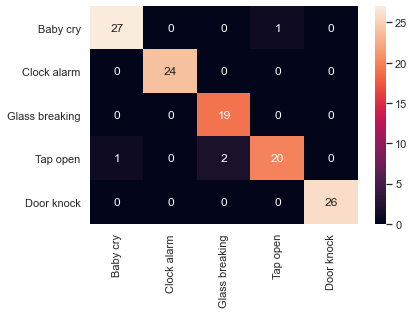

In [24]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

array = [[27,  0,  0,  1,  0],
 [ 0,  24,  0,  0,  0],
 [ 0,  0,  19,  0,  0],
 [ 1,  0,  2, 20,  0],
 [ 0,  0,  0,  0,  26]]
target_names=['Baby cry','Clock alarm','Glass breaking','Tap open','Door knock']
df_cm = pd.DataFrame(array,target_names,target_names)
sn.set(font_scale=1.0) 
sn.color_palette("mako", as_cmap=True)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 12}) 

plt.show()